# Tag 1

In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
# get indices of k-th diagonal elements of n x n matrix
def offdiag_indices(n, k):
    """Returns a tuple of arrays that hold the indices of the elements on the k-th diagonal.
    k = 0 will return the indices of the elements on the main diagonal
    k > 0 will return the indices of the elements on the diagonal k lines above the main diagonal
    k < 0 will return the indices of the elements on the diagonal k lines below the main diagonal
    """
    import numpy as np
    if (k==0):
        return (np.arange(n), (np.arange(n)+k+n)%n)
    elif (k<0):
        return (np.arange(n)[-k:], np.arange(n)[:k])
    else:
        return (np.arange(n)[:-k], (np.arange(n)+k+n)[:-k]%n)

F: [ 20.   14.7   0.    0.  -10. ]
T: [ 20.   24.8  29.6  19.7   9.8  -0.1 -10. ]


<IPython.core.display.Javascript object>


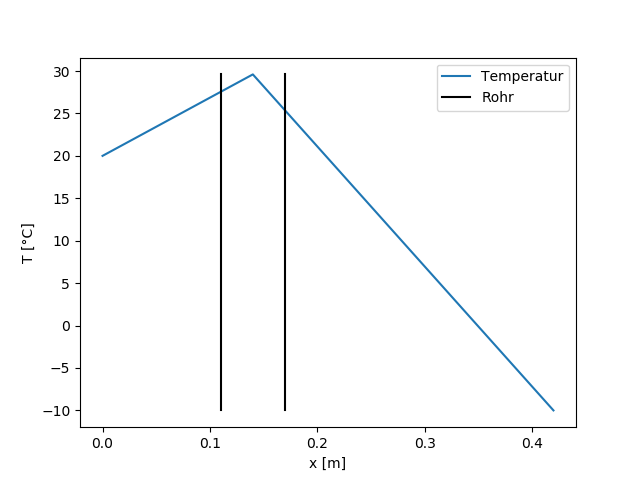

In [3]:
# 1. Materialparam kappa, Randwerte T, Quellterme S
kappa = 0.1
TA = 20
TB = -10
S_Rohr = 300  #W/m^3

# 2. Diskretiesierung von x, S
x = 0.07*arange(7)
T = zeros(len(x))
T[0] = TA
T[-1]= TB
S = zeros(len(x))
S[2] = S_Rohr

# 3. Berechnung Vektor F (K x = F)
dx = x[1]-x[0]
F = dx**2/kappa*S[1:-1]
F[0] += T[0]
F[-1]+= T[-1]
print('F:',F)

# 4. Aufstellen der Koeffizientenmatrix K
K = zeros((len(T)-2, len(T)-2))


K[offdiag_indices(len(x)-2, 0)]  = 2
K[offdiag_indices(len(x)-2, 1)]  = -1
K[offdiag_indices(len(x)-2, -1)] = -1

# 5. Lösen des Gleichungssystems
T[1:-1] = linalg.lstsq(K, F)[0]
print('T:', T)

# 6. Ergebnis darstellen
figure()
plot(x, T, label='Temperatur')
plot([0.11,0.11], [min(T),max(T)], 'k', label='Rohr')
plot([0.17,0.17], [min(T),max(T)], 'k')
xlabel('x [m]')
ylabel('T [°C]')
legend()

Populating the interactive namespace from numpy and matplotlib
[ 20.   0.   0.   0. -10.]
0.74267169964


<IPython.core.display.Javascript object>


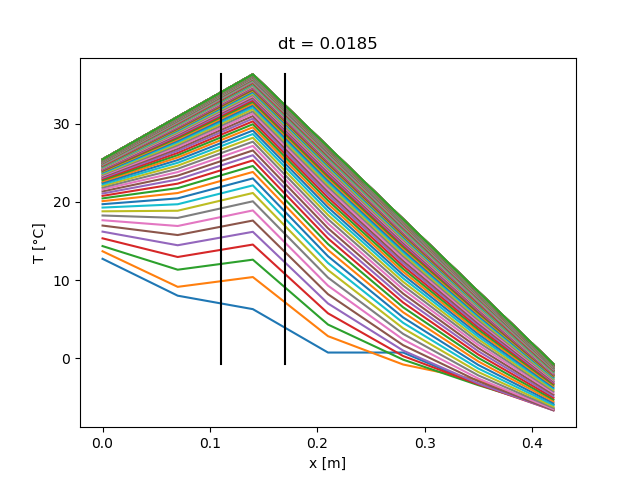

In [5]:
%pylab notebook
# 1.2 explizites Verfahren
# define dt
dt = 1.85e-2
nstep = int(ceil(3/dt))
a = kappa*dt/dx**2

# redefine K and F, and S
T = zeros(len(T))
T[0] = TA
T[-1]= TB
F[1:-1] = 0
print(F)

# T0
T0 = linalg.solve(K, F)[0]
T[1:-1] = T0
print(T0)

fig= figure()
ax = fig.add_subplot(111)
for istep in range(nstep):
    T += dt*S + a*(hstack((TA, T[:-1])) -2*T + hstack((T[1:], TB)))
    ax.plot(x, T)
plot([0.11,0.11], [min(T),max(T)], 'k', label='Rohr')
plot([0.17,0.17], [min(T),max(T)], 'k')
title('dt = '+str(dt))
xlabel('x [m]')
ylabel('T [°C]');

<IPython.core.display.Javascript object>


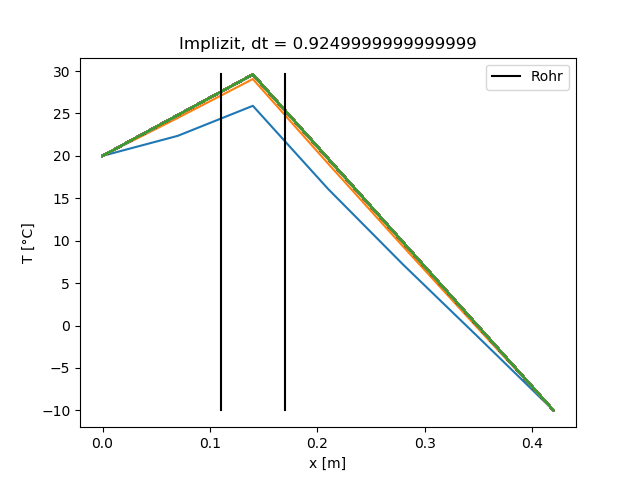

In [6]:
# 1.3 implizites Verfahren
# Vorfaktoren
dt = 50*1.85e-2
a = kappa*dt/dx**2
b = 1+2*a

## redefine K and F, and S
T = zeros(len(T))
T[0] = TA
T[-1]= TB
S[2] = S_Rohr

K[offdiag_indices(len(T)-2, 0)]  = b
K[offdiag_indices(len(T)-2, 1)]  = -a
K[offdiag_indices(len(T)-2, -1)] = -a


# plot
fig = figure()
ax = fig.add_subplot(111)
for istep in range(nstep):
    F = T[1:-1] + dt*S[1:-1]
    F[0] += a*TA
    F[-1]+= a*TB
    # solve
    T[1:-1] = linalg.lstsq(K, F)[0]
    ax.plot(x, T)

plot([0.11,0.11], [min(T),max(T)], 'k', label='Rohr')
plot([0.17,0.17], [min(T),max(T)], 'k')
title('Implizit, dt = '+str(dt))
xlabel('x [m]')
ylabel('T [°C]')
legend()

<br><br><br><br>

<IPython.core.display.Javascript object>


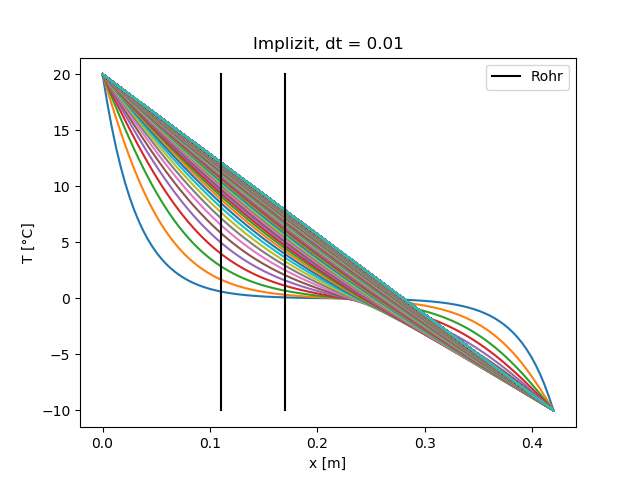

In [8]:
# 2.1 Finite Elemente
# 1. Materialparam kappa, Randwerte T, Quellterme S
kappa = 0.1
wallwidth = 0.42 # m
TA = 20  # °C
TB = -10 # °C
S_Rohr = 300  #W/m^3

# 2. Diskretiesierung von x, S, Mesh bauen
nel = 6
nnod = nel+1
nnodel = 2

x = linspace(0, wallwidth, nnod) #gcoord
dx = x[1] - x[0]

bcdof = array([0, -1])
bcval = array([TA, TB])
T = zeros(len(x))
T[bcdof] = bcval

S = zeros(len(x))
#S[2] = S_Rohr
#nodes = arange(nel+1)
#N1 = zeros((len(nodes), len(x)))
#for i in range(len(N[0,:])):
#    N1[i,:] = 1 - x/dx
#N2 = 1-N1

# 3. Elementmatrizen Me, Ke, Fe
Me = zeros((2, 2))
Ke = zeros((2, 2))
Fe = zeros((2,1))

Me[offdiag_indices(2,0)] = dx/3
Me[offdiag_indices(2,1)] = dx/6
Me[offdiag_indices(2,-1)]= dx/6
Ke[offdiag_indices(2,0)] = kappa/dx
Ke[offdiag_indices(2,1)] = -kappa/dx
Ke[offdiag_indices(2,-1)] = -kappa/dx
Fe[:] = S[0]/dx
    
# 4. Koeffizientenmatrizen Re, Le aufsetzen
dt = 1e-2
Re = 1/dt * Me
Le = 1/dt * Me + Ke

# 5. globale Matrizen und Vektor aufsetzen
R = zeros((nnod, nnod))
L = zeros((nnod, nnod))
F = zeros((nnod, 1))
for e in range(nel):
    R[e:e+2,e:e+2] = R[e:e+2,e:e+2] + Re
    L[e:e+2,e:e+2] = L[e:e+2,e:e+2] + Le
    F[e:e+2] += Fe
    
# 6. Zeitschleife
fig = figure()
ax = fig.add_subplot(111)
nstep = int(ceil(3/dt))
for istep in range(nstep):
    b = matmul(R,T) + F - matmul(L[:,bcdof],bcval)
    # solve
    T[1:-1] = linalg.solve(L[1:-1,1:-1], b[0,1:-1])
    # plot
    ax.plot(x, T)
    
plot([0.11,0.11], [min(T),max(T)], 'k', label='Rohr')
plot([0.17,0.17], [min(T),max(T)], 'k')
title('Implizit, dt = '+str(dt))
xlabel('x [m]')
ylabel('T [°C]')
legend()

# Tag 2

In [9]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


/home/noah/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


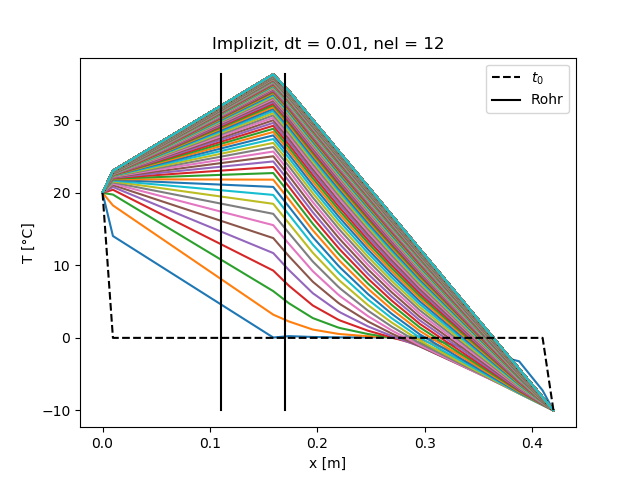

Wärmefluss am linken Rand: 31.3043885036 W/m
Wärmefluss am rechten Rand: -17.873926965 W/m


In [10]:
### Tests ###
# 1) kappa x <= Rohr >> kappa > Rohr
# 2) nur TA setzen, S > 0
# 3) nur TB setzen, S > 0
# 4) nel = 100
# 5) kappa[-1] = 10**-4 * kappa[0]
# 6) Wärmefluss in/aus Domain 
#    q = kappa[0]*([dN1/dx  dN2/dx]) * T(el2nod[:,0])
#      = kappa[0]*matmul(array([-1/Le, 1/Le]), T[0,1])
# 7) Variable Elemetlänge


# 2.1 Finite Elemente
# 1. Materialparam kappa, Randwerte T, Quellterme S
kappa = 0.1      # m^2/s
wallwidth = 0.42 # m
xRohr = array([0.11, 0.17])
TA = 20          # °C
TB = -10         # °C
S_Rohr = 300     # W/m^3

# 2. Diskretiesierung von x, S, Mesh bauen
nel = 12 #100
nnod = nel+1
nnodel = 2

# variable element length (Test 7) )
gcoord = hstack((0, sort(rand(nnod-2)*wallwidth), wallwidth))
lElem = gcoord[1:]-gcoord[:-1]

kappa = ones(len(gcoord))*kappa
#kappa[(x>xRohr[1])] /= 1000      # Test 1)
#kappa[-1] = 10**(-4) * kappa[0]  # Test 5)

bcdof = array([0, -1])
bcval = array([TA, TB])
T = zeros(len(gcoord))
T[bcdof] = bcval
T0 = T.copy()

S = zeros(len(gcoord))
S[(gcoord>=0.11) * (gcoord<=0.17)] = S_Rohr


# 5. globale Matrizen und Vektor aufsetzen
R = zeros((nnod, nnod))
L = zeros((nnod, nnod))
F = zeros(nnod)
    
for e in range(nel):
    # 3. Elementmatrizen Me, Ke, Fe
    Me = zeros((2, 2))
    Ke = zeros((2, 2))
    Fe = zeros((2,1))

    Me[offdiag_indices(2,0)] = lElem[e]/3
    Me[offdiag_indices(2,1)] = lElem[e]/6
    Me[offdiag_indices(2,-1)]= lElem[e]/6
    Ke[offdiag_indices(2,0)] = kappa[e]/lElem[e]
    Ke[offdiag_indices(2,1)] = -kappa[e]/lElem[e]
    Ke[offdiag_indices(2,-1)] = -kappa[e]/lElem[e]
    Fe = mean(S[e:e+2])*lElem[e]

    # 4. Koeffizientenmatrizen Re, Le aufsetzen
    dt = 1e-2
    Re = 1/dt * Me
    Le = 1/dt * Me + Ke

    #for e in range(nel):
    R[e:e+2,e:e+2] = R[e:e+2,e:e+2] + Re
    L[e:e+2,e:e+2] = L[e:e+2,e:e+2] + Le
    F[e:e+2] += Fe
    
# 6. Zeitschleife
fig = figure()
ax = fig.add_subplot(111)
nstep = int(ceil(3/dt))
for istep in range(nstep):
    b = matmul(R,T) + F - matmul(L[:,bcdof],bcval)
    # solve
    T[1:-1] = linalg.solve(L[1:-1,1:-1], b[1:-1])
    # plot
    ax.plot(gcoord, T)
    
# plot initial condition, tube boundaries
ax.plot(gcoord, T0, 'k--', label=r'$t_0$')
ax.plot([0.11,0.11], [min(T),max(T)], 'k', label='Rohr')
ax.plot([0.17,0.17], [min(T),max(T)], 'k')
title('Implizit, dt = '+str(dt)+', nel = '+str(nel))
xlabel('x [m]')
ylabel('T [°C]')
legend()

# Test 6) Berechnung Wärmefluss
q = kappa[0]*matmul(array([-1/lElem[0], 1/lElem[0]]), T[0:2].T)
print('Wärmefluss am linken Rand:',q,'W/m')
print('Wärmefluss am rechten Rand:', kappa[-1]*matmul(array([-1/lElem[-1], 1/lElem[-1]]), T[-2:].T), 'W/m')

### Gauß-Legendre-Quadratur

<IPython.core.display.Javascript object>


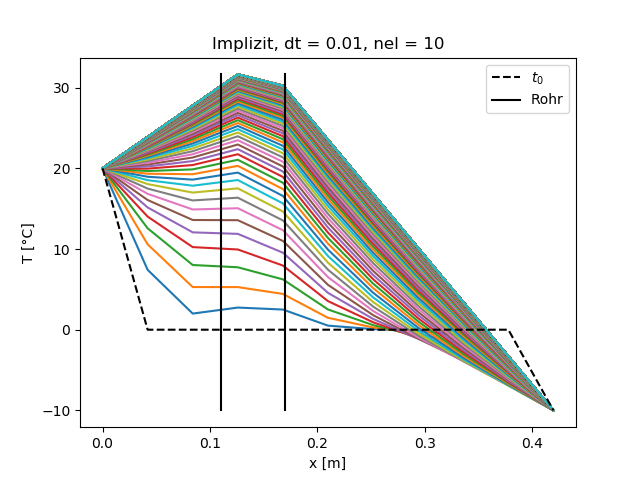

Wärmefluss am linken Rand:  9.23714204729 W/m
Wärmefluss am rechten Rand: -15.962856333 W/m


In [11]:
# 3.1 Einbau von numerischer Integration nach Geuß-Legendre-Quadratur
#     Trafo globale -> lokale Variablen x = lElem/2*(x+1)

# 1. Materialparam kappa, Wanddicke, Position d. Rohrs, Randwerte T, Quellterme S
kappa = 0.1      # m^2/s
wallwidth = 0.42 # m
xRohr = array([0.11, 0.17])
TA = 20          # °C
TB = -10         # °C
S_Rohr = 300     # W/m^3
dt = 1e-2        # s

nel = 10 #100
nnodel = 2
nnod = nel+1+nel*(nnodel-2)


gcoord = linspace(0, wallwidth, nnod)
#gcoord = hstack((0, sort(rand(nnod-2)*wallwidth), wallwidth))   # Test 7) variable element length
lElem = gcoord[1:]-gcoord[:-1]

kappa = ones(len(gcoord))*kappa
#kappa[(x>xRohr[1])] /= 1000      # Test 1)
#kappa[-1] = 10**(-4) * kappa[0]  # Test 5)

bcdof = array([0, -1])
bcval = array([TA, TB])
T = zeros(len(gcoord))
T[bcdof] = bcval
T0 = T.copy()

S = zeros(len(gcoord))
S[(gcoord>=0.11) * (gcoord<=0.17)] = S_Rohr

# 2. Ansatzfunktionen und deren Ableitung definieren
def N1(xi):
    return 0.5*(1-xi)
def N2(xi):
    return 0.5*(1+xi)
#def dN1(xi):
#    return -0.5
#def dN2(xi):
#    return 0.5
dN1 = -0.5
dN2 = 0.5

# 3. Integratiospunkte und Gewichte definieren
nip = 2
x, W = numpy.polynomial.legendre.leggauss(nip)

# globale Matrizen und Vektor aufsetzen
R = zeros((nnod, nnod))
L = zeros((nnod, nnod))
F = zeros(nnod)
J = 0.5*lElem
    
# Zeitschleife
fig = figure()
ax = fig.add_subplot(111)
nstep = int(ceil(3/dt))
for istep in range(nstep):
    
    # Elementschleife
    for e in range(nel):
        # 4. Elementmatrizen Me, Ke, Fe initialisieren
        Me = zeros((nnodel, nnodel))
        Ke = zeros((nnodel, nnodel))
        Fe = zeros(nnodel)

        # a) Funktionswerte d Ansatzfkt Ni berechnen
        # b) mit Gewichten W multiplizieren
        # c) globale -> lokale Koords transformieren (xi = lElem/2*(x+1))
        # d) Summieren
        Me[offdiag_indices(2,0)] = sum(0.5*lElem[e] *W *N1(lElem[e]/2*(x+1)) *N1(lElem[e]/2*(x+1)))
        Me[offdiag_indices(2,1)] = sum(0.5*lElem[e] *W *N1(lElem[e]/2*(x+1)) *N2(lElem[e]/2*(x+1)))
        Me[offdiag_indices(2,-1)]= sum(0.5*lElem[e] *W *N2(lElem[e]/2*(x+1)) *N1(lElem[e]/2*(x+1)))
        Ke[offdiag_indices(2,0)] = kappa[e] * 2/lElem[e]*sum(W *array([dN1, dN1]) *array([dN1, dN1]))
        Ke[offdiag_indices(2,1)] = kappa[e] * 2/lElem[e]*sum(W *array([dN1, dN2]) *array([dN2, dN1]))
        Ke[offdiag_indices(2,-1)]= kappa[e] * 2/lElem[e]*sum(W *array([dN2, dN1]) *array([dN1, dN2]))
        Fe[0] = sum(W *N1(J[e]*(x+1)))
        Fe[1] = sum(W *N2(J[e]*(x+1)))
        Fe *= S[e:e+2]*J[e]
        
        Re = 1/dt * Me
        Le = 1/dt * Me + Ke

        R[e:e+2,e:e+2] = R[e:e+2,e:e+2] + Re
        L[e:e+2,e:e+2] = L[e:e+2,e:e+2] + Le
        F[e:e+2] += Fe
    
    # solve and plot
    b = matmul(R,T) + F - matmul(L[:,bcdof],bcval)
    T[1:-1] = linalg.solve(L[1:-1,1:-1], b[1:-1])
    ax.plot(gcoord, T)
    
# plot initial condition, tube boundaries
ax.plot(gcoord, T0, 'k--', label=r'$t_0$')
ax.plot([0.11,0.11], [min(T),max(T)], 'k', label='Rohr')
ax.plot([0.17,0.17], [min(T),max(T)], 'k')
title('Implizit, dt = '+str(dt)+', nel = '+str(nel))
xlabel('x [m]')
ylabel('T [°C]')
legend()

# Test 6) Berechnung Wärmefluss
q = kappa[0]*matmul(array([-1/lElem[0], 1/lElem[0]]), T[0:2].T)
print('Wärmefluss am linken Rand: ',q,'W/m')
print('Wärmefluss am rechten Rand:', kappa[-1]*matmul(array([-1/lElem[-1], 1/lElem[-1]]), T[-2:].T), 'W/m')

In [359]:
e=0

In [363]:
def dN1(xi):
    return -0.5
def dN2(xi):
    return 0.5
N = array([N1(0.5*lElem[e]*(x+1)), N2(0.5*lElem[e]*(x+1))]).T
dN= array([dN1(0.5*lElem[e]*(x+1)), dN2(0.5*lElem[e]*(x+1))]).T
kappa[e] *2/lElem[e] *outer(dN*W, dN*W.T)

array([[ 1.19047619, -1.19047619],
       [-1.19047619,  1.19047619]])

In [364]:
N

array([[ 0.49556218,  0.50443782],
       [ 0.48343782,  0.51656218]])

In [365]:
N.T

array([[ 0.49556218,  0.48343782],
       [ 0.50443782,  0.51656218]])

In [361]:
dN1 = -0.5
dN2 = 0.5
Ke[offdiag_indices(2,0)] = kappa[e] * 2/lElem[e]*sum(W *array([dN1, dN1]) *array([dN1, dN1]))
Ke[offdiag_indices(2,1)] = kappa[e] * 2/lElem[e]*sum(W *array([dN1, dN2]) *array([dN2, dN1]))
Ke[offdiag_indices(2,-1)]= kappa[e] * 2/lElem[e]*sum(W *array([dN2, dN1]) *array([dN1, dN2]))
print(Ke)

[[ 2.38095238 -2.38095238]
 [-2.38095238  2.38095238]]


In [ ]:
N = array([N1(0.5*lElem[e]*(x+1)), N2(0.5*lElem[e]*(x+1))]).T
dN= array([dN1(0.5*lElem[e]*(x+1)), dN2(0.5*lElem[e]*(x+1))]).T
Me = 0.5*lElem[e] *sum(outer(N*W,N*W.T), axis=0).reshape(nnodel,nnodel)
Ke = kappa[e] *0.5*lElem[e] *outer(dN*W, dN*W.T) *nnodel

<br><br><br><br>

<IPython.core.display.Javascript object>


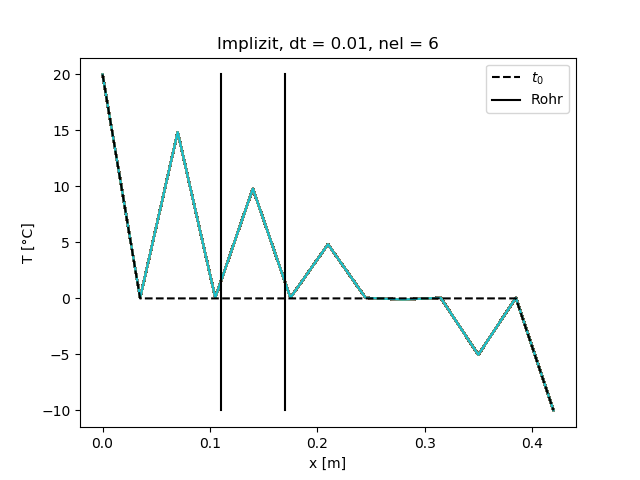

In [14]:
# 3.2 Quadratische Elemente
#     nnodes variabel (2 oder 3)
#     outer product für Me, Ke ..

# 1. Materialparam kappa, Wanddicke, Position d. Rohrs, Randwerte T, Quellterme S
kappa = 0.1      # m^2/s
wallwidth = 0.42 # m
xRohr = array([0.11, 0.17])
TA = 20          # °C
TB = -10         # °C
S_Rohr = 300     # W/m^3
dt = 1e-2        # s
nstep = int(ceil(3/dt))

nel = 6 #100
nnodel = 3
nnod = nel+1+nel*(nnodel-2)

def el2nod(elemID):
    return elemID*(nnodel-2)*2

gcoord = linspace(0, wallwidth, nnod)
lElem = gcoord[1::nnodel-1]-gcoord[:-1:nnodel-1]

kappa = ones(len(gcoord))*kappa

bcdof = array([0, -1])
bcval = array([TA, TB])
T = zeros(nnod)
T[bcdof] = bcval
T0 = T.copy()

S = zeros(nnod)
S[(gcoord>=0.11) * (gcoord<=0.17)] = S_Rohr

# 2. Ansatzfunktionen und deren Ableitung definieren
def N1(xi):
    return 0.5*xi*(xi-1)
def N2(xi):
    return 1-xi**2
def N3(xi):
    return 0.5*xi*(xi+1)
def dN1(xi):
    return xi-0.5
def dN2(xi):
    return 2*xi
def dN3(xi):
    return xi+0.5

# 3. Integratiospunkte und Gewichte definieren
nip = nnodel
x, W = numpy.polynomial.legendre.leggauss(nip)

# globale Matrizen und Vektor aufsetzen
R = zeros((nnod, nnod))
L = zeros((nnod, nnod))
F = zeros(nnod)
#J = outer(dN.T, dN)
    
# Zeitschleife
fig = figure()
ax = fig.add_subplot(111)
for istep in range(nstep):
    
    # Elementschleife
    for e in range(nel):
        # 4. Elementmatrizen Me, Ke, Fe initialisieren
        Me = zeros((nnodel, nnodel))
        Ke = zeros((nnodel, nnodel))
        Fe = zeros(nnodel)
  
        # Schleife über Integrationspunkte
        for i in range(nip):
    
        # Ansatzfunktionen in Vektor für outer product
            N = array([N1(0.5*lElem[e]*(x[i]+1)), N2(0.5*lElem[e]*(x[i]+1)), N3(0.5*lElem[e]*(x[i]+1))]).T
            dN= array([dN1(0.5*lElem[e]*(x[i]+1)), dN2(0.5*lElem[e]*(x[i]+1)), dN3(0.5*lElem[e]*(x[i]+1))]).T
            n1 = el2nod(e)

            Me += outer(N,N)*W[i]
            Ke +=  outer(dN, dN)
            Fe[0] = sum(W *N1(0.5*lElem[e]*(x+1)))
            Fe[1] = sum(W *N2(0.5*lElem[e]*(x+1)))
        
        Re = 1/dt * Me*0.5*lElem[e]
        Le = 1/dt * Me + Ke *kappa[e]*2/lElem[e]

        R[n1:n1+nnodel, n1:n1+nnodel] += Re
        L[n1:n1+nnodel, n1:n1+nnodel] += Le
        F[n1:n1+nnodel] += Fe *mean(S[n1:n1+nnodel])*0.5*lElem[e]
    
    # solve and plot
    b = matmul(R,T) + F - matmul(L[:,bcdof],bcval)
    T[1:-1] = linalg.solve(L[1:-1,1:-1], b[1:-1])
    ax.plot(gcoord, T)
    
# plot initial condition, tube boundaries
ax.plot(gcoord, T0, 'k--', label=r'$t_0$')
ax.plot([0.11,0.11], [min(T),max(T)], 'k', label='Rohr')
ax.plot([0.17,0.17], [min(T),max(T)], 'k')
title('Implizit, dt = '+str(dt)+', nel = '+str(nel))
xlabel('x [m]')
ylabel('T [°C]')
legend()

like it was before:
        N = array([N1(0.5*lElem[e]*(x+1)), N2(0.5*lElem[e]*(x+1)), N3(0.5*lElem[e]*(x+1))]).T
        dN= array([dN1(0.5*lElem[e]*(x+1)), dN2(0.5*lElem[e]*(x+1)), dN3(0.5*lElem[e]*(x+1))]).T
        n1 = el2nod(e)
        
        Me = 0.5*lElem[e] *sum(outer(N*W,N*W.T), axis=0).reshape(nnodel,nnodel)
        Ke = kappa[e] *2/lElem[e] *sum(outer(dN*W, dN*W.T), axis=0).reshape(nnodel,nnodel)
        Fe[0] = sum(W *N1(0.5*lElem[e]*(x+1)))
        Fe[1] = sum(W *N2(0.5*lElem[e]*(x+1)))
        Fe *= mean(S[n1:n1+nnodel])*0.5*lElem[e]

In [430]:
shape(L)

(13, 13)

In [432]:
L

array([[  -73.18015098,  1246.04826374,    74.33178996,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [  -76.37982772,  1251.95220016,    81.67353942,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [  -79.43661077,  1257.39887679,    15.97803159,  1246.04826374,
           74.33178996,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,   -76.37982772,  1251.95220016,
           81.67353942,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.      

In [388]:
# globale Matrizen und Vektor aufsetzen
R = zeros((nnod, nnod))
L = zeros((nnod, nnod))
F = zeros(nnod)
print('shape L:', shape(L))

# 4. Elementmatrizen Me, Ke, Fe initialisieren
Me = zeros((nnodel, nnodel))
Ke = zeros((nnodel, nnodel))
Fe = zeros(nnodel)


# Ansatzfunktionen in Vektor für outer product
N = array([N1(0.5*lElem[e]*(x+1)), N2(0.5*lElem[e]*(x+1)), N3(0.5*lElem[e]*(x+1))]).T
dN= array([dN1(0.5*lElem[e]*(x+1)), dN2(0.5*lElem[e]*(x+1)), dN3(0.5*lElem[e]*(x+1))]).T
Me = 0.5*lElem[e] *sum(outer(N*W,N*W.T), axis=0).reshape(nnodel,nnodel)
Ke = kappa[e] *2/lElem[e] *sum(outer(dN*W, dN*W.T), axis=0).reshape(nnodel,nnodel)
Fe[0] = sum(W *N1(0.5*lElem[e]*(x+1)))
Fe[1] = sum(W *N2(0.5*lElem[e]*(x+1)))
Fe *= mean(S[e:e+nnodel])*0.5*lElem[e]


Re = 1/dt * Me
Le = 1/dt * Me + Ke
print('shape Le:', shape(Le))

R[e:e+nnodel,e:e+nnodel] = R[e:e+nnodel,e:e+nnodel] + Re
L[e:e+nnodel,e:e+nnodel] = L[e:e+nnodel,e:e+nnodel] + Le
print(shape(L))
F[e:e+nnodel] += Fe

shape L: (13, 13)
shape Le: (3, 3)
(13, 13)


# Tag 3
### 2D

Populating the interactive namespace from numpy and matplotlib


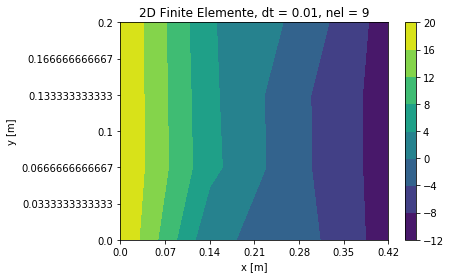

In [225]:
%pylab inline
# globale Koordinaten gcoord in 2D
nel = 3**2            # Anzahl Elemente
n = int(sqrt(9))      # Anzahl Elemente pro Dimension in quadratischer Anordnung
nnod = (n+1)**2       # Gesamtanzahl Knoten
nnodel = n+1          # Knoten pro Element

indexs = arange(nnod).reshape(n+1,n+1)
el2nod = zeros((n+1,nel))
el2nod[0,:] = indexs[:n,:n].flatten()
el2nod[1,:] = indexs[:n,1:].flatten()
el2nod[2,:] = indexs[1:,1:].flatten()
el2nod[3,:] = indexs[1:,:n].flatten()
el2nod = el2nod.astype(int).T


# Parameter
dt = 1e-2         # s Zeitschritt
ndt = int(ceil(3/dt)) # Anzahl der Zeitschritte
kappa = 0.1      # m^2/s
kappa = array([kappa,0,0,kappa]).reshape(2,2)
Lx = 0.42        # m Wanddicke x
Ly = 0.20        # m Wanddicke y
xRohr = array([0.11, 0.17])
gcoord = vstack((array([(linspace(0,Lx,n+1).tolist())*4]), linspace(0,Ly,n+1).repeat(n+1)))

TA = 20          # °C
TB = -10         # °C
T = zeros((n+1,n+1))
bcdof = array([0,-1])
bcval = array([TA, TB])
T[:,bcdof] = bcval
T = T.flatten()
ifree = where(T==0)
S_Rohr = 300      # W/m^3
S = zeros((n+1,n+1))
#S[:,(gcoord[0,:nnodel]>=0.11) * (gcoord[0,:nnodel]<=0.17)] = S_Rohr   # xz-Schnitt
S = S.flatten()
#S[5] = S_Rohr*100    # xy-Schnitt


# Ansatzfunktionen
def Ni(xi,eta):
    return 0.25*array([(1-xi)*(1-eta), (1+xi)*(1-eta), (1+xi)*(1+eta), (1-xi)*(1+eta)])
def dNi(xi,eta):
    res = vstack((0.25*array([-(1-eta), 1-eta, 1+eta, -(1+eta)]), \
                  0.25*array([-(1-xi), -(1+xi), 1+xi, 1-xi])))
    return res


nip = nnodel
xloc, W = numpy.polynomial.legendre.leggauss(int(sqrt(nip)))
xi = array((xloc.tolist()*2))
eta= xloc.repeat(2)
W = outer(W.T, W).flatten()

R = zeros((nnod, nnod))
L = zeros((nnod, nnod))
F = zeros(nnod)

# Zeitschleife
for istep in range(ndt):
    # Schleife über Elemente
    for el in range(nel):
        Me = zeros((nnodel, nnodel))
        Ke = zeros((nnodel, nnodel))
        Fe = zeros(nnodel)
        # Schleife über Integrationspunkte
        for i in range(nip):
            N = Ni(xi[i],eta[i])
            dN = dNi(xi[i],eta[i])
            J = matmul(dN, gcoord[:,el2nod[el]].T)
            dN = linalg.solve(J, dN)

            Me += outer(N.T, N) *det(J) *W[i]
            Ke += matmul( matmul(dN.T,kappa), dN ) *det(J) *W[i]
            Fe += S[el] *N *det(J) *W[i]

        Re = 1/dt * Me
        Le = 1/dt * Me + Ke

        iel = meshgrid(el2nod[el],el2nod[el])
        R[iel] += Re
        L[iel] += Le
        F[el2nod[el]] += Fe


# solve and plot
b = matmul(R,T) + F - matmul(L[:,bcdof],bcval)
T[ifree] = linalg.solve(L[meshgrid(ifree,ifree)], b[ifree])
contourf(T.reshape(n+1,n+1))
    
title('2D Finite Elemente, dt = '+str(dt)+', nel = '+str(nel))
xlabel('x [m]'); ylabel('y [m]');
gca().set_xticklabels(gca().get_xticks()/n*max(gcoord[0]));
gca().set_yticklabels(gca().get_yticks()/n*max(gcoord[1]));
colorbar(contourf(T.reshape(n+1,n+1)))

In [226]:
T.reshape(4,4)

array([[ 20.        ,   0.90340938,  -2.15228343, -10.        ],
       [ 20.        ,   5.15586317,  -3.02836627, -10.        ],
       [ 20.        ,   4.84668182,  -3.07574453, -10.        ],
       [ 20.        ,   4.40400064,  -0.95199498, -10.        ]])

# Tag 4
### 2D Sparse

In [320]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


/home/noah/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


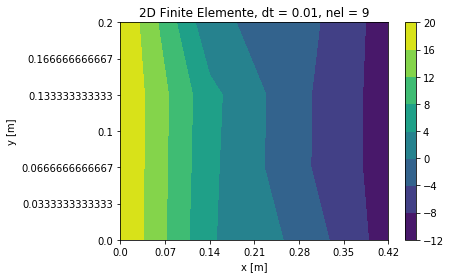

In [39]:
%pylab inline
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
# full matrix: a.todense()

# globale Koordinaten gcoord in 2D
nel = 3**2            # Anzahl Elemente
n = int(sqrt(nel))    # Anzahl Elemente pro Dimension in quadratischer Anordnung
nnod = (n+1)**2       # Gesamtanzahl Knoten
nnodel = 4            # Knoten pro Element

indexs = arange(nnod).reshape(n+1,n+1)
el2nod = zeros((nnodel,nel))
el2nod[0,:] = indexs[:n,:n].flatten()
el2nod[1,:] = indexs[:n,1:].flatten()
el2nod[2,:] = indexs[1:,1:].flatten()
el2nod[3,:] = indexs[1:,:n].flatten()
el2nod = el2nod.astype(int).T


# Parameter
dt = 1e-2         # s Zeitschritt
ndt = int(ceil(3/dt)) # Anzahl der Zeitschritte
kappa = 0.1      # m^2/s
kappa = array([kappa,0,0,kappa]).reshape(2,2)
Lx = 0.42        # m Wanddicke x
Ly = 0.20        # m Wanddicke y
xRohr = array([0.11, 0.17])
gcoord = vstack((array([(linspace(0,Lx,n+1).tolist())*(n+1)]), linspace(0,Ly,n+1).repeat(n+1)))

TA = 20          # °C
TB = -10         # °C
T = zeros((n+1,n+1))
bcdof = array([0,-1])
bcval = array([TA, TB])
T[:,bcdof] = bcval
T = T.flatten()
ifree = where(T==0)[0]  # nur für den Fall, dass Ränder ungleich 0 sind
S_Rohr = 30      # W/m^3
S = zeros((n,n))
#S[:,1] = S_Rohr   # xz-Schnitt
S = S.flatten()
#S[4] = 30    # xy-Schnitt
#S[:] = 30


# Ansatzfunktionen
def Ni(xi,eta):
    return 0.25*array([(1-xi)*(1-eta), (1+xi)*(1-eta), (1+xi)*(1+eta), (1-xi)*(1+eta)])
def dNi(xi,eta):
    res = vstack((0.25*array([-(1-eta), 1-eta, 1+eta, -(1+eta)]), \
                  0.25*array([-(1-xi), -(1+xi), 1+xi, 1-xi])))
    return res


nip = nnodel
xloc, W = numpy.polynomial.legendre.leggauss(int(sqrt(nip)))
xi = array((xloc.tolist()*2))
eta= xloc.repeat(2)
W = outer(W.T, W).flatten()

F = zeros(nnod)

ig = zeros((nnodel**2,nel))
jg = zeros((nnodel**2,nel))
Lv = zeros((nnodel**2,nel))
Rv = zeros((nnodel**2,nel))

# Zeitschleife
for istep in range(ndt):
    # Schleife über Elemente
    for el in range(nel):
        Me = zeros((nnodel, nnodel))
        Ke = zeros((nnodel, nnodel))
        Fe = zeros(nnodel)
        # Schleife über Integrationspunkte
        for i in range(nip):
            #print('Integrationspunkt: ', xi[i], eta[i])
            N = Ni(xi[i],eta[i])
            dN = dNi(xi[i],eta[i])

            J = matmul(dN, gcoord[:,el2nod[el]].T)
            dN = linalg.solve(J, dN)

            Me += outer(N.T, N) *det(J) *W[i]
            Ke += matmul( matmul(dN.T,kappa), dN ) *det(J) *W[i]
            Fe += S[el] *N *det(J) *W[i]

        Re = 1/dt * Me
        Le = 1/dt * Me + Ke
        
        # calc indices of non-zero elements in sparse matrix
        idof = outer(el2nod[el], ones(nnodel))
        jdof = idof.T
        ig[:,el] = idof.flatten()
        jg[:,el] = jdof.flatten()

        Lv[:,el] = Le.flatten()
        Rv[:,el] = Re.flatten()
        
        F[el2nod[el]] += Fe
        
    L = csc_matrix((Lv.flatten(), (ig.flatten(), jg.flatten())))
    R = csc_matrix((Rv.flatten(), (ig.flatten(), jg.flatten())))


# solve and plot
b = R*T + F - L[:,bcdof]*bcval
lif = len(ifree)
T[ifree] = spsolve(L[ifree.repeat(lif), ifree.tolist()*lif].reshape(lif,lif), b[ifree])
    
title('2D Finite Elemente, dt = '+str(dt)+', nel = '+str(nel))
xlabel('x [m]'); ylabel('y [m]');
gca().set_xticklabels(linspace(0,n,2*n+1)/n*max(gcoord[0]));
gca().set_yticklabels(linspace(0,n,2*n+1)/n*max(gcoord[1]));
colorbar(contourf(T.reshape(n+1,n+1)[-1::-1]));

## Porous Flow
$$\vec{v} = -\frac{K}{\mu_f}(\nabla P -\rho_f \vec{g})$$

Populating the interactive namespace from numpy and matplotlib


/home/noah/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


<IPython.core.display.Javascript object>


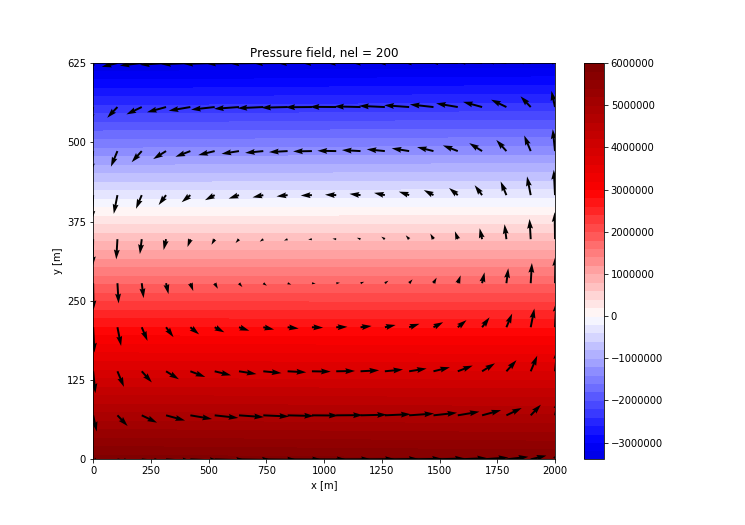

In [419]:
%pylab notebook
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.constants import g

# Parameter
nelx = 20        # Anzahl Elemente in x
nely = 10        # Anzahl Elemente in y
nnodel = 4       # Knoten pro Element
g = array([0,-g])# m/s^2 Erdbeschleunigung
kappa = 1        # m^2/s
Lx = 2000        # m Domainlänge in x-Richtung
Ly = 1000        # m Domainlänge in y-Richtung
K = 40e-05       # m^2
müf = 1          # Pa s
rho0 = 1000      # kg/m^3
TA = 50          # °C
TB = 70          # °C
alpha = 1e-3     # K^-1

# abgeleitete Parameter
nel = nelx*nely             # Gesamtzahl Elemente
nx, ny = nelx+1, nely+1
nnod = nx*ny                # Gesamtanzahl Knoten


indexs = arange(nnod).reshape(ny,nx)
el2nod = zeros((nnodel,nelx*nely))
el2nod[0,:] = indexs[:nely,:nelx].flatten()
el2nod[1*s,:] = indexs[:nely,1:].flatten()
el2nod[2*s,:] = indexs[1:,1:].flatten()
el2nod[3*s,:] = indexs[1:,:nelx].flatten()
el2nod = el2nod.astype(int).T
ifree = arange(nnod)

K = array([K,0,0,K]).reshape(2,2)/müf
gcoord = vstack((array([(linspace(0,Lx,nx).tolist())*(ny)]), linspace(0,Ly,ny).repeat(nx)))

P = zeros(nnod)
V = zeros((2, nel))

T = zeros((nely,nelx))
T[:] = linspace(TA, TB, nelx)
T = T.flatten()
rhof = rho0*(1-alpha*T)


# Ansatzfunktionen und Ableitungn
def Ni(xi,eta):
    return 0.25*array([(1-xi)*(1-eta), (1+xi)*(1-eta), (1+xi)*(1+eta), (1-xi)*(1+eta)])
def dNi(xi,eta):
    res = vstack((0.25*array([-(1-eta), 1-eta, 1+eta, -(1+eta)]), \
                  0.25*array([-(1-xi), -(1+xi), 1+xi, 1-xi])))
    return res


# Größen für Integrationspunkte
nip = nnodel
xloc, W = numpy.polynomial.legendre.leggauss(int(sqrt(nip)))
xi = array((xloc.tolist()*2))
eta= xloc.repeat(2)
W = outer(W.T, W).flatten()

ig = zeros((nnodel**2,nel))
jg = zeros((nnodel**2,nel))
Kv = zeros((nnodel**2,nel))
F = zeros(nnod)

for el in range(nel):               # Elementschleife
    Me = zeros((nnodel, nnodel))    #
    Ke = zeros((nnodel, nnodel))    #
    Fe = zeros(nnodel)              #
                                    #
    for i in range(nip):                # Schleife über Integrationspunkte
        N = Ni(xi[i],eta[i])
        dN = dNi(xi[i],eta[i])
        J = matmul(dN, gcoord[:,el2nod[el]].T)
        dN = linalg.solve(J, dN)

        Ke += matmul( matmul(dN.T,K), dN ) *det(J) *W[i]
        Fe += matmul( matmul(dN.T,K), g ) *rhof[el] *det(J) *W[i]

    # calc indices of non-zero elements in sparse matrix for element el
    idof = outer(el2nod[el], ones(nnodel))
    jdof = idof.T
    ig[:,el] = idof.flatten()
    jg[:,el] = jdof.flatten()

    Kv[:,el] = Ke.flatten()

    F[el2nod[el]] += Fe

# convert Kv to sparse matrix (LHS in L x = b) and solve for x
L = csc_matrix((Kv.flatten(), (ig.flatten(), jg.flatten())))
lif = len(ifree)
P[ifree] = spsolve(L[ifree.repeat(lif), ifree.tolist()*lif].reshape(lif,lif), F[ifree])


def ve(el):
    """Calculate the Element Velocity according to Darcy's Law v= -K/nu_f *(grad(P)-rho_f *g)
        input: el  -  Element ID (number)"""
    dN = dNi(0,0)
    J = matmul(dN, gcoord[:,el2nod[el]].T)
    dN = linalg.solve(J, dN)
    #print(P[el2nod[el]])
    return matmul(-K, matmul(dN, P[el2nod[el]].T) -rhof[el]*g)

# use pressure P to calculate particle Velocity v_e
for el in range(nel):
    V[:,el] = ve(el)


title('Pressure field, nel = '+str(nel))
xlabel('x [m]'); ylabel('y [m]');
vlim = max(abs(P))
colorbar(contourf(P.reshape(nely+1,nelx+1), 50, vmax=vlim, vmin=-vlim, cmap='seismic'))
gca().set_xticklabels((gca().get_xticks()/nx*gcoord[0,-1]).astype(int));
gca().set_yticklabels((gca().get_yticks()/ny*gcoord[1,-1]).astype(int));

quiver(arange(nelx)/(nelx-1)*nelx, arange(nely)/(nely-1)*nely, V[0].reshape(nely,nelx),V[1].reshape(nely,nelx))

Populating the interactive namespace from numpy and matplotlib


/home/noah/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


<IPython.core.display.Javascript object>


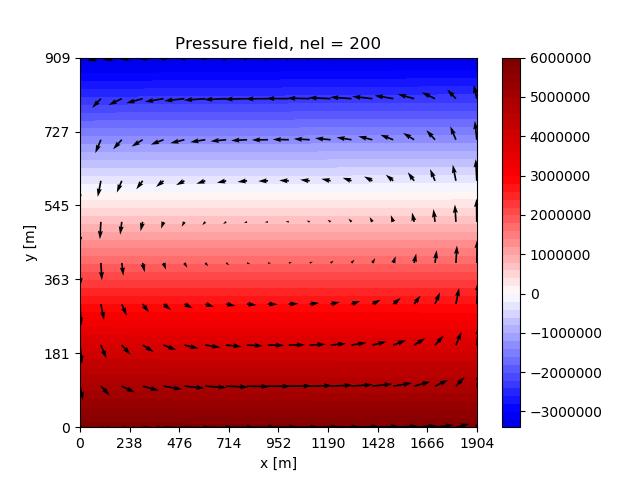

In [1]:
%pylab notebook
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.constants import g

# Parameter
nelx = 20        # Anzahl Elemente in x
nely = 10        # Anzahl Elemente in y
nnodel = 4       # Knoten pro Element
g = array([0,-g])# m/s^2 Erdbeschleunigung
kappa = 1        # m^2/s
Lx = 2000        # m Domainlänge in x-Richtung
Ly = 1000        # m Domainlänge in y-Richtung
K = 40e-05       # m^2
müf = 1          # Pa s
rho0 = 1000      # kg/m^3
TA = 50          # °C
TB = 70          # °C
alpha = 1e-3     # K^-1

# abgeleitete Parameter
nel = nelx*nely             # Gesamtzahl Elemente
nx, ny = nelx+1, nely+1
nnod = nx*ny                # Gesamtanzahl Knoten


indexs = arange(nnod).reshape(ny,nx)
el2nod = zeros((nnodel,nelx*nely))
el2nod[0,:] = indexs[:nely,:nelx].flatten()
el2nod[1,:] = indexs[:nely,1:].flatten()
el2nod[2,:] = indexs[1:,1:].flatten()
el2nod[3,:] = indexs[1:,:nelx].flatten()
el2nod = el2nod.astype(int).T
ifree = arange(nnod)

K = array([K,0,0,K]).reshape(2,2)/müf
gcoord = vstack((array([(linspace(0,Lx,nx).tolist())*(ny)]), linspace(0,Ly,ny).repeat(nx)))

P = zeros(nnod)
V = zeros((2, nel))

T = zeros((nely,nelx))
T[:] = linspace(TA, TB, nelx)
T = T.flatten()
rhof = rho0*(1-alpha*T)


# Ansatzfunktionen und Ableitungn
def Ni(xi,eta):
    return 0.25*array([(1-xi)*(1-eta), (1+xi)*(1-eta), (1+xi)*(1+eta), (1-xi)*(1+eta)])
def dNi(xi,eta):
    res = vstack((0.25*array([-(1-eta), 1-eta, 1+eta, -(1+eta)]), \
                  0.25*array([-(1-xi), -(1+xi), 1+xi, 1-xi])))
    return res


# Größen für Integrationspunkte
nip = nnodel
xloc, W = numpy.polynomial.legendre.leggauss(int(sqrt(nip)))
xi = array((xloc.tolist()*2))
eta= xloc.repeat(2)
W = outer(W.T, W).flatten()

ig = zeros((nnodel**2,nel))
jg = zeros((nnodel**2,nel))
Kv = zeros((nnodel**2,nel))
F = zeros(nnod)

for el in range(nel):               # Elementschleife
    Me = zeros((nnodel, nnodel))    #
    Ke = zeros((nnodel, nnodel))    #
    Fe = zeros(nnodel)              #
                                    #
    for i in range(nip):                # Schleife über Integrationspunkte
        N = Ni(xi[i],eta[i])
        dN = dNi(xi[i],eta[i])
        J = matmul(dN, gcoord[:,el2nod[el]].T)
        dN = linalg.solve(J, dN)

        Ke += matmul( matmul(dN.T,K), dN ) *det(J) *W[i]
        Fe += matmul( matmul(dN.T,K), g ) *rhof[el] *det(J) *W[i]

    # calc indices of non-zero elements in sparse matrix for element el
    idof = outer(el2nod[el], ones(nnodel))
    jdof = idof.T
    ig[:,el] = idof.flatten()
    jg[:,el] = jdof.flatten()

    Kv[:,el] = Ke.flatten()

    F[el2nod[el]] += Fe

# convert Kv to sparse matrix (LHS in L x = b) and solve for x
L = csc_matrix((Kv.flatten(), (ig.flatten(), jg.flatten())))
lif = len(ifree)
P[ifree] = spsolve(L[ifree.repeat(lif), ifree.tolist()*lif].reshape(lif,lif), F[ifree])


def ve(el):
    """Calculate the Element Velocity according to Darcy's Law v= -K/nu_f *(grad(P)-rho_f *g)
        input: el  -  Element ID (number)"""
    dN = dNi(0,0)
    J = matmul(dN, gcoord[:,el2nod[el]].T)
    dN = linalg.solve(J, dN)
    #print(P[el2nod[el]])
    return matmul(-K, matmul(dN, P[el2nod[el]].T) -rhof[el]*g)

# use pressure P to calculate particle Velocity v_e
for el in range(nel):
    V[:,el] = ve(el)


title('Pressure field, nel = '+str(nel))
xlabel('x [m]'); ylabel('y [m]');
vlim = max(abs(P))
colorbar(contourf(P.reshape(nely+1,nelx+1), 50, vmax=vlim, vmin=-vlim, cmap='seismic'))
gca().set_xticklabels((gca().get_xticks()/nelx*gcoord[0,-1]).astype(int));
gca().set_yticklabels((gca().get_yticks()/nely*gcoord[1,-1]).astype(int));

quiver(arange(nelx)/(nelx-1)*nelx, arange(nely)/(nely-1)*nely, V[0].reshape(nely,nelx),V[1].reshape(nely,nelx))

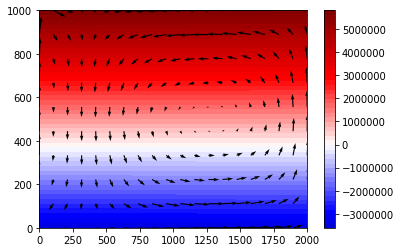

In [80]:
### -successful Test calcVel
#   -successful Test assemble for Pressure
#   -successful Test assemble for Temperature

%pylab inline
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.constants import g
from IPython import display

# Parameter
nelx = 20        # Anzahl Elemente in x
nely = 10        # Anzahl Elemente in y
nnodel = 4       # Knoten pro Element
dt = 3600        # s Zeitschritt
ndt = int(ceil(3600*24/dt)) # Anzahl der Zeitschritte
g = array([0,-g])# m/s^2 Erdbeschleunigung
kappa = 1        # m^2/s
Lx = 2000        # m Domainlänge in x-Richtung
Ly = 1000        # m Domainlänge in y-Richtung
K = 40e-05       # m^2
müf = 1          # Pa s
rho0 = 1000      # kg/m^3
TA = 50          # °C
TB = 70          # °C
alpha = 1e-3     # K^-1

# abgeleitete Parameter
nel = nelx*nely             # Gesamtzahl Elemente
nx, ny = nelx+1, nely+1
nnod = nx*ny                # Gesamtanzahl Knoten


indexs = arange(nnod).reshape(ny,nx)
el2nod = zeros((nnodel,nelx*nely))
el2nod[0,:] = indexs[:nely,:nelx].flatten()
el2nod[1,:] = indexs[:nely,1:].flatten()
el2nod[2,:] = indexs[1:,1:].flatten()
el2nod[3,:] = indexs[1:,:nelx].flatten()
el2nod = el2nod.astype(int).T
ifree = arange(nnod)

K = array([K,0,0,K]).reshape(2,2)/müf
gcoord = vstack((array([(linspace(0,Lx,nx).tolist())*(ny)]), linspace(0,Ly,ny).repeat(nx)))

P = zeros(nnod)
V = zeros((2, nel))

S = zeros(nnod)
S[gcoord[0,:]<100] = 5e-3

T = zeros((ny,nx))
T[:] = linspace(TA, TB, nx)
T = T.flatten()

# Ansatzfunktionen und Ableitungn
def Ni(xi,eta):
    return 0.25*array([(1-xi)*(1-eta), (1+xi)*(1-eta), (1+xi)*(1+eta), (1-xi)*(1+eta)])
def dNi(xi,eta):
    res = vstack((0.25*array([-(1-eta), 1-eta, 1+eta, -(1+eta)]), \
                  0.25*array([-(1-xi), -(1+xi), 1+xi, 1-xi])))
    return res

t= 0
istep =0
# Zeitschleife
#for istep in range(ndt):
while t<=3600*24:
    rhof = rho0*(1-alpha*mean(T[el2nod[:]], axis=1))
    # Druck
    L, R, b = assembleDiffusion(gcoord,el2nod, 40e-05*ones(nel), 1, rhof)
    lif = len(ifree)
    P[ifree] = spsolve(L[ifree.repeat(lif), ifree.tolist()*lif].reshape(lif,lif), b[ifree])
    V = calcVel(P, rhof, gcoord,el2nod, 40e-05*ones(nel), müf, g)

    if (istep%3==0):
        title('Pressure field, nel = '+str(nel))
        xlabel('x [m]'); ylabel('y [m]');
        vlim = max(abs(P))
        clf()
        contourf(P.reshape(nely+1,nelx+1)[-1::-1], 50, vmax=vlim, vmin=-vlim, cmap='seismic')
        colorbar()
        gca().set_xticklabels((gca().get_xticks()/nelx*gcoord[0,-1]).astype(int));
        gca().set_yticklabels((gca().get_yticks()/nely*gcoord[1,-1]).astype(int));
        #display.display(gcf())
        quiver(arange(nelx)/(nelx-1)*nelx, arange(nely)/(nely-1)*nely, V[0].reshape(nely,nelx),V[1].reshape(nely,nelx))
        display.display(gcf())
        display.clear_output(wait=True)
    
    T, bcdof, bcval = setBoundaryConditions(T, gcoord,el2nod, nelx, val_left=TA, val_right=TB)
    dt = 0.05 *min(Lx/amax(abs(V[0,:])), Ly/amax(abs(V[1,:])))
    L, R, F = assembleDiffusion(gcoord,el2nod, kappa*ones(nel), dt=dt, S=S, assTemp=True)
    b = R*T + F
    T = spsolve(L, b)
    istep += 1
    t += dt

# Tag 5
## Porous Flow mit Zeitschleife über Dichte, Druck, Geschwindigkeit, dt 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib
